# KKS Binary Solidification with FiPy
This notebook contains code for binary solidification using the
Kim-Kim-Suzuki model [1] for interfacial energy. This allows easy specification
of gamma, but requires constant chemical potential through the interface.
The implementation involves iteratively solving for chemical composition in
pure phases such that the chemical potential constraint is satisfied [2].

Questions/comments to trevor.keller@nist.gov (Trevor Keller)

References:

[1] Kim, Kim, and Suzuki. "Phase-field model for binary alloys."
    _Physical Review E_ 60:6;7186-7197 (1999).
    
[2] Provatas and Elder. _Phase-Field Methods in Materials Science and Engineering_,
    Chapter 6, Section 9. Wiley VCH: Weinheim, Germany. 2010.


In [50]:
%matplotlib inline
from fipy import CellVariable, DiffusionTerm, Grid2D, Matplotlib2DGridViewer, MultiViewer, Solver, TransientTerm, Variable, Viewer
from fipy.tools import numerix as nmx
import numpy as np

In [38]:
# Spacetime parameters
nx = ny = 64       # domain size
dx = dy = 0.075    # mesh resolution
dt = Variable(0.1) # initial timestep

# Grid and scalar fields
mesh = Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)
x, y = mesh.cellCenters
phase = CellVariable(mesh=mesh, hasOld=True)
conc  = CellVariable(mesh=mesh, hasOld=True)
Cs  = CellVariable(mesh=mesh, hasOld=False)
Cl  = CellVariable(mesh=mesh, hasOld=False)

# Default boundary conditions are... ?

## Thermodynamics
The free energy curves for solid and liquid were computed using PyCalphad, fit with 10<sup>_th_</sup>-order polynomials. Planned upgrades will include equivalent OpenCalphad calls (via PyOC) with SymPy to achieve this without human intervention. For now, we'll risk using the hand-coded result.

In [12]:
# Define polynomial coefficients from curve fitting to CALPHAD
calCs = (6.19383857e+03,-3.09926825e+04, 6.69261368e+04,-8.16668934e+04, \
         6.19902973e+04,-3.04134700e+04, 9.74968659e+03,-2.04529002e+03, \
         2.95622845e+02,-3.70962613e+01,-6.12900561e+01)
calCl = (6.18692878e+03,-3.09579439e+04, 6.68516329e+04,-8.15779791e+04, \
         6.19257214e+04,-3.03841489e+04, 9.74145735e+03,-2.04379606e+03, \
         2.94796431e+02,-3.39127135e+01,-6.26373908e+01)

# Define bulk free energy curves
def fs(c_):
    return   calCs[0]*c_**10 + calCs[1]*c_**9 + calCs[2]*c_**8 + calCs[3]*c_**7 \
           + calCs[4]*c_**6  + calCs[5]*c_**5 + calCs[6]*c_**4 + calCs[7]*c_**3 \
           + calCs[8]*c_**2  + calCs[9]*c_    + calCs[10]
def fl(c_):
    return   calCl[0]*c_**10 + calCl[1]*c_**9 + calCl[2]*c_**8 + calCl[3]*c_**7 \
           + calCl[4]*c_**6  + calCl[5]*c_**5 + calCl[6]*c_**4 + calCl[7]*c_**3 \
           + calCl[8]*c_**2  + calCl[9]*c_    + calCl[10]

# Define first derivatives
def dfs_dc(c_):
    return  10.0*calCs[0]*c_**9 + 9.0*calCs[1]*c_**8 + 8.0*calCs[2]*c_**7 \
           + 7.0*calCs[3]*c_**6 + 6.0*calCs[4]*c_**5 + 5.0*calCs[5]*c_**4 \
           + 4.0*calCs[6]*c_**3 + 3.0*calCs[7]*c_**2 + 2.0*calCs[8]*c_ \
           + calCs[9];
def dfl_dc(c_):
    return  10.0*calCl[0]*c_**9 + 9.0*calCl[1]*c_**8 + 8.0*calCl[2]*c_**7 \
           + 7.0*calCl[3]*c_**6 + 6.0*calCl[4]*c_**5 + 5.0*calCl[5]*c_**4 \
           + 4.0*calCl[6]*c_**3 + 3.0*calCl[7]*c_**2 + 2.0*calCl[8]*c_ \
           + calCl[9];
            
# Define second derivatives
def d2fs_dc2(c_):
    return   90.0*calCs[0]*c_**8 + 72.0*calCs[1]*c_**7 + 56.0*calCs[2]*c_**6 \
           + 42.0*calCs[3]*c_**5 + 30.0*calCs[4]*c_**4 + 20.0*calCs[5]*c_**3 \
           + 12.0*calCs[6]*c_**2 +  6.0*calCs[7]*c_    +  2.0*calCs[8]
def d2fl_dc2(c_):
    return   90.0*calCl[0]*c_**8 + 72.0*calCl[1]*c_**7 + 56.0*calCl[2]*c_**6 \
           + 42.0*calCl[3]*c_**5 + 30.0*calCl[4]*c_**4 + 20.0*calCl[5]*c_**3 \
           + 12.0*calCl[6]*c_**2 +  6.0*calCl[7]*c_    +  2.0*calCl[8]

# Equilibrium properties (from solving dfl/dc = 0, etc.)
Cse = 0.48300
Cle = 0.33886

## Initial Condition
For testing, the domain contains two circular solid seeds of different radius. The entire domain starts with the same composition.

In [39]:
def initialize():
    # Flat field initializations
    conc[:] = (Cse + Cle)/2.
    phase[:] = 0.
    Cs[:] = (Cse + Cle)/2.
    Cl[:] = (Cse + Cle)/2.
    
    # Initial microstructure
    rA = 20.*dx
    rB = 16.*dx
    cA = (     nx * dx / 3.,      ny * dy / 3.)
    cB = (3. * nx * dx / 4., 3. * ny * dy / 4.)
    mask = ((x - cA[0])**2 + (y - cA[1])**2 < rA**2) + \
           ((x - cB[0])**2 + (y - cB[1])**2 < rB**2)
    phase.setValue(1., where=mask)

initialize()

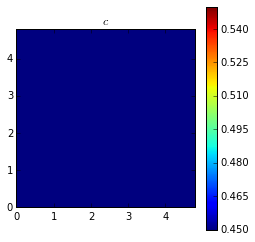

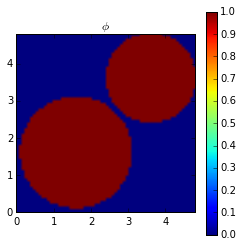

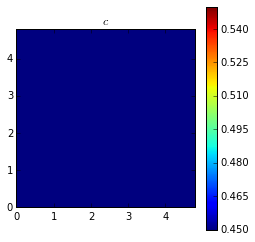

In [56]:
# Visualize initial conditions
viewer = MultiViewer(viewers = (Viewer(vars=phase, title='$\phi$'), \
                                Viewer(vars=conc,  title='$c$')))
viewer.plot()

# Can these be forced into a row, instead of a column?